# **Segmentación del riesgo LAFT**
**Parte 1**

**Presentado por _Luis Hernando Benitez_**

# Segmentación del riesgo LAFT para Banco Amigo.
En cumplimiento de las obligaciones impuestas por la superintendencia financiera los bancos deben segmentar el riesgo LAFT de sus clientes y productos.
 
El “Banco Amigo” necesita realizar la segmentación de las cuentas de personas naturales asociadas al producto “Cuenta de nómina Empresa” para identificar grupos de riesgo e identificar alertas de riesgo LAFT en este grupo de clientes.
 
## Objetivos del negocio.
- Cumplir con las imposiciones de la superintendencia financiera segmentando los productos y clientes de productos bancarios.
 
- Identificar los grupos de clientes y servicios relacionados con un riesgo LAFT y las variables transaccionales asociadas.
 
## Metas del proyecto.
- Presentar varias opciones de segmentación usando diferentes algoritmos de clustering.
 
- Lograr un coeficiente de silueta superior o igual al 0.5 como mínimo entre los clusters
 
- No obtener más del 30% de los datos agrupados en un segmento (por recomendación de la superintendencia financiera)


In [ ]:
import pandas as pd
import numpy as np
#--------------visualizaciones
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import plotly

import plotly.graph_objs as go 
import plotly.express as px
import plotly.figure_factory as ff

# Configuraciones de Matplotlib
%matplotlib inline   
plt.rcParams['figure.dpi'] = 110
sns.set_theme('notebook')
sns.set_palette("Set2")

## 1. Carga de datos
Estos datos son proporcionados por stradata SAS de manera anonima

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/UNAL/DiplomadoML/modulo 2 - Introduc a ML con Python/U6 - Proyecto aplicado/Data/DATA_SET_LUIS.csv")

In [ ]:
df

,ID,ACT_ECO,CIIU,RIESGO_CIIU,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS,PATRIMONIO,fecha_constitucion,TIPO_SOCIEDAD,ENTIDAD,CAPTACIONES_CREDITO,TRX_CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,TRX_CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,TRX_COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,TRX_COLOCACIONES_DEBITO,EFECTIVO_CREDITO,TRX_EFECTIVO_CREDITO,EFECTIVO_DEBITO,TRX_EFECTIVO_DEBITO
0,Row2,Servicios,9499,Medio Alto,1.023400e+06,0.000000e+00,3.440460e+06,0.000000e+00,1.023400e+05,3.440460e+06,20190130,Ent. Sin Animo De L,Fundaciones,0.000000e+00,2,9.913503e+05,59,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0
1,Row3,Servicios,9499,Medio Alto,1.535100e+05,0.000000e+00,1.025351e+06,0.000000e+00,1.840871e+06,1.025351e+06,20120503,No Aplica,Otro,9.367633e+06,66,4.520988e+04,56,0.0,0,0.0,0,1.842120e+05,2,1.698844e+07,28
2,Row5,Servicios,9499,Medio Alto,2.895693e+06,0.000000e+00,1.887046e+07,0.000000e+00,2.895692e+06,1.887046e+07,20160429,Ent. Sin Animo De L,Establecimiento Publico,6.388056e+06,547,1.339631e+04,69,0.0,0,0.0,0,1.381100e+07,74,4.387177e+07,50
3,Row7,Industrial,161,Medio Bajo,0.000000e+00,0.000000e+00,5.798390e+05,0.000000e+00,0.000000e+00,5.798390e+05,20151026,Ent. Sin Animo De L,Establecimiento Publico,1.582790e+02,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0
4,Row8,Servicios,9499,Medio Alto,0.000000e+00,0.000000e+00,5.117000e+06,0.000000e+00,1.023400e+00,5.117000e+06,20190503,Ent. Sin Animo De L,Otro,1.206896e+07,47,1.479953e+07,128,0.0,0,0.0,0,9.722300e+05,6,0.000000e+00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17429,Row60305,Servicios,8890,Bajo,1.023400e+05,5.117000e+04,1.023400e+06,0.000000e+00,0.000000e+00,1.023400e+06,20160404,Ent. Sin Animo De L,Establecimiento Publico,7.575207e+01,15,0.000000e+00,0,0.0,0,0.0,0,5.117000e+04,1,0.000000e+00,0
17430,Row60306,Servicios,9609,Bajo,4.093600e+06,0.000000e+00,7.188362e+04,0.000000e+00,0.000000e+00,7.188362e+04,20151215,Ent. Sin Animo De L,Establecimiento Publico,3.597251e+01,14,0.000000e+00,0,0.0,0,0.0,0,0.000000e+00,0,0.000000e+00,0
17431,Row60320,Servicios,9499,Medio Alto,0.000000e+00,0.000000e+00,1.931136e+06,0.000000e+00,1.023400e+05,1.931136e+06,20190923,No Aplica,Otro,7.265691e+07,292,9.132706e+07,372,0.0,0,0.0,0,1.214515e+07,33,0.000000e+00,0
17432,Row60323,Servicios,9499,Medio Alto,5.117000e+05,0.000000e+00,5.117000e+05,0.000000e+00,1.023400e+05,5.117000e+05,20190404,Ent. Sin Animo De L,Corporaciones Y Asociaciones,1.017225e+07,18,6.173024e+04,35,0.0,0,0.0,0,8.187200e+04,1,1.361122e+07,26


## 2. Descripción y preparación de los datos



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17434 entries, 0 to 17433
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   ID                        17434 non-null  object 
 1   ACT_ECO                   17434 non-null  object 
 2   CIIU                      17434 non-null  int64  
 3   RIESGO_CIIU               17427 non-null  object 
 4   INGRESOS                  17431 non-null  float64
 5   EGRESOS                   17434 non-null  float64
 6   ACTIVOS                   17434 non-null  float64
 7   PASIVOS                   17434 non-null  float64
 8   VENTAS                    17434 non-null  float64
 9   PATRIMONIO                17434 non-null  float64
 10  fecha_constitucion        17434 non-null  int64  
 11  TIPO_SOCIEDAD             17434 non-null  object 
 12  ENTIDAD                   17434 non-null  object 
 13  CAPTACIONES_CREDITO       17434 non-null  float64
 14  TRX_CA

* **ACT_ECO:** Describe la actividad económica. Puede ser “SERVICIOS”, “VENTA”, entre otros.
* **CIIU:** Código CIIU que corresponde a la actividad desarrollada 
* **RIESGO_CIIU:** Nivel de riesgo CIIU que va de “BAJO” a “ALTO”. Directamente relacionado con la actividad y el riesgo LAFT
* **INGRESOS:** Total ingresos registrados
* **EGRESOS:** Total de egresos
* **ACTIVOS:** Total activos
* **PASIVOS:** Total de pasivos
* **VENTAS:** Total de ventas
* **PATRIMONIO:** Total de patrimonio. 
* **fecha_constitucion:** Fecha de constitución de la empresa presentado como entero
* **TIPO_SOCIEDAD:** Tipo de sociedad de la empresa
* **ENTIDAD:** Tipo de entidad como “COOPERATIVA”, “Sociedad Anonima”, entre otros
* **CAPTACIONES_CREDITO:** Montos que ingresan a las cuentas por concepto de créditos
* **TRX_CAPTACIONES_CREDITO** Frecuencia de las transacciones (promedio mensual)
* **CAPTACIONES_DEBITO:** montos que ingresan a las cuentas por concepto de débitos
* **TRX_CAPTACIONES_DEBITO** Frecuencia de las transacciones (promedio mensual)
* **COLOCACIONES_CREDITO** Montos que se ponen en circulación por concepto de credito
* **TRX_COLOCACIONES_CREDITO** Frecuencia de las transacciones (promedio mensual)
* **COLOCACIONES_DEBITO** Montos que se ponen en circulación por concepto de debito
* **TRX_COLOCACIONES_DEBITO** Frecuencia de las transacciones (promedio mensual)
* **EFECTIVO_CREDITO** Operaciones en efectivo por concepto de créditos
* **TRX_EFECTIVO_CREDITO** Frecuencia de las transacciones (promedio mensual)
* **EFECTIVO_DEBITO** Operaciones en efectivo por concepto de debitos
* **TRX_EFECTIVO_DEBITO** Frecuencia de las transacciones (promedio mensual)


### 2.1 Eliminando columnas innecesarias

In [ ]:
df.drop("ID", axis=1, inplace=True)

### 2.2 Verifica si no existen valores duplicados

In [ ]:
dups= df[df.duplicated()]#marca el segundo duplicado

In [ ]:
dups

,ACT_ECO,CIIU,RIESGO_CIIU,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS,PATRIMONIO,fecha_constitucion,TIPO_SOCIEDAD,ENTIDAD,CAPTACIONES_CREDITO,TRX_CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,TRX_CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,TRX_COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,TRX_COLOCACIONES_DEBITO,EFECTIVO_CREDITO,TRX_EFECTIVO_CREDITO,EFECTIVO_DEBITO,TRX_EFECTIVO_DEBITO
10503,Otra,312,Bajo,511700.0,204680.0,122194.9834,0.0,0.0,122194.9834,20130213,Ent. Sin Animo De L,Corporaciones Y Asociaciones,74.462584,14,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0
16484,Servicios,9499,Medio Alto,0.0,0.0,187922.8484,0.0,0.0,187922.8484,20160308,Ent. Sin Animo De L,Establecimiento Publico,96.342876,14,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0


Hay dos filas duplicadas, se eliminan de los datos

In [ ]:
df.drop_duplicates(inplace=True)

In [ ]:
df.shape # -2 filas menos

(17432, 24)

### 2.1 Tratamiento de valores vacios

Hay algunos valores nulos en los datos. A continuación se revisa detalladamente

In [ ]:
def get_nulos(df):
  """
    Permite identificar los valores vacios y entrega un informe de texto plano
    recibe un dataframe
    retorna variables vacias con mas del 85%, 60% y menos del 60%
  """
  nulos = df.isnull().sum()
  null_85 = list()
  null_60 = list()
  null_menos_60 = list()
  for i,val in enumerate(nulos):
    if val>0:
      per_nuls = (val/len(df)) *100
      if per_nuls < 60:
          null_menos_60.append({"var": str(nulos.index[i]), "porcentaje": str(per_nuls)})
      elif per_nuls > 60 and per_nuls < 85:
          null_60.append({"var": str(nulos.index[i]), "porcentaje": str(per_nuls)})
      else:
          null_85.append({"var": str(nulos.index[i]), "porcentaje": str(per_nuls)})
      print("VARIABLE NULA:", nulos.index[i], "| TOTAL VACIOS: ", val, "| Porcentaje nulos : ", per_nuls)
      print("\n ---VALORES UNICOS", df[nulos.index[i]].unique())
      print("========================================================================================================\n")
  return null_85,null_60,null_menos_60
        

In [ ]:
null_85,null_60,null_menos_60 = get_nulos(df)

VARIABLE NULA: RIESGO_CIIU | TOTAL VACIOS:  7 | Porcentaje nulos :  0.04015603487838458

 ---VALORES UNICOS ['Medio Alto' 'Medio Bajo' 'Bajo' 'Medio' nan 'Alto']

VARIABLE NULA: INGRESOS | TOTAL VACIOS:  3 | Porcentaje nulos :  0.01720972923359339

 ---VALORES UNICOS [1.02340000e+06 1.53510000e+05 2.89569290e+06 ... 1.20037544e+07
 5.50077500e+05 1.33985692e+08]



Los valores vacios son solo 5 datos en total. Debido a que esto no representa ni siquiera el 1% de la población se decide eliminar

In [ ]:
df.dropna(inplace=True)
df.isna().sum()#comprobamos que no existan mas valores vacios

ACT_ECO                     0
CIIU                        0
RIESGO_CIIU                 0
INGRESOS                    0
EGRESOS                     0
ACTIVOS                     0
PASIVOS                     0
VENTAS                      0
PATRIMONIO                  0
fecha_constitucion          0
TIPO_SOCIEDAD               0
ENTIDAD                     0
CAPTACIONES_CREDITO         0
TRX_CAPTACIONES_CREDITO     0
CAPTACIONES_DEBITO          0
TRX_CAPTACIONES_DEBITO      0
COLOCACIONES_CREDITO        0
TRX_COLOCACIONES_CREDITO    0
COLOCACIONES_DEBITO         0
TRX_COLOCACIONES_DEBITO     0
EFECTIVO_CREDITO            0
TRX_EFECTIVO_CREDITO        0
EFECTIVO_DEBITO             0
TRX_EFECTIVO_DEBITO         0
dtype: int64

## 3. Análisis descriptivo de los datos.

In [ ]:
df.describe()

,CIIU,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS,PATRIMONIO,fecha_constitucion,CAPTACIONES_CREDITO,TRX_CAPTACIONES_CREDITO,CAPTACIONES_DEBITO,TRX_CAPTACIONES_DEBITO,COLOCACIONES_CREDITO,TRX_COLOCACIONES_CREDITO,COLOCACIONES_DEBITO,TRX_COLOCACIONES_DEBITO,EFECTIVO_CREDITO,TRX_EFECTIVO_CREDITO,EFECTIVO_DEBITO,TRX_EFECTIVO_DEBITO
count,17422.000000,1.742200e+04,1.742200e+04,1.742200e+04,1.742200e+04,1.742200e+04,1.742200e+04,1.742200e+04,1.742200e+04,17422.000000,1.742200e+04,17422.000000,1.742200e+04,17422.000000,1.742200e+04,17422.000000,1.742200e+04,17422.000000,1.742200e+04,17422.000000
mean,8732.502239,1.595405e+08,9.666361e+07,1.604172e+09,4.583494e+08,8.366086e+08,1.145823e+09,2.005532e+07,4.328798e+08,248.068993,2.905149e+08,295.118700,1.494853e+08,5.975663,2.126431e+08,0.755826,4.646978e+07,55.328952,1.176486e+08,30.317472
std,1801.423321,2.824407e+09,1.735296e+09,4.736174e+10,1.320059e+10,1.757496e+10,3.806502e+10,6.117201e+05,5.729846e+09,2644.150260,3.549172e+09,1341.660684,6.982811e+09,136.075728,1.044628e+10,13.967652,5.113244e+08,509.288616,2.428226e+09,120.938595
min,111.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.499096e+10,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
25%,8559.000000,9.517620e+04,0.000000e+00,6.652100e+05,0.000000e+00,1.023400e+00,5.006984e+05,2.007041e+07,9.634288e+01,14.000000,0.000000e+00,1.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,0.000000e+00,0.000000
50%,9499.000000,1.188156e+06,0.000000e+00,5.117000e+06,0.000000e+00,5.117000e+06,4.093600e+06,2.014107e+07,1.306111e+06,27.000000,5.076255e+04,25.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,1.023400e+05,1.000000,1.792019e+06,2.000000
75%,9499.000000,1.023400e+07,1.427528e+06,4.093600e+07,2.829701e+05,7.246809e+07,3.070200e+07,2.017090e+07,3.555144e+07,135.000000,7.494086e+05,146.000000,0.000000e+00,0.000000,0.000000e+00,0.000000,5.771464e+06,9.000000,2.463859e+07,23.000000
max,9900.000000,2.343514e+11,1.559648e+11,4.208552e+12,1.114065e+12,1.948830e+12,3.552196e+12,2.203102e+07,4.617914e+11,318567.000000,2.495395e+11,56188.000000,6.419369e+11,10998.000000,9.599513e+11,1118.000000,2.481354e+10,34362.000000,1.791718e+11,8896.000000


### 3.1 ACT_ECO

In [ ]:
df['ACT_ECO'].value_counts()

Servicios              16013
Ninguna                  415
Otra                     364
Vender Y/o Comprar       224
Comercial                202
Industrial               133
Transporte                56
Asalariado                12
Rentista De Capital        3
Name: ACT_ECO, dtype: int64

In [ ]:
data = df['ACT_ECO'].value_counts(dropna=False)
data_labels = list(data.index)
data_values = list(data.values)

In [ ]:
fig = px.pie(df, values=data_values, names=data_labels, color_discrete_sequence=px.colors.qualitative.Set3)
fig.show()

La mayoria de registros se concentran en "Servicios". Por lo cual la variable **ACT_ECO** no es una opcion a considerar para utilizar en el entrenamiento como variable categorica

### 3.2 CIIU
Es un codigo que identifica la actividad y sobre el cual se puede asignar el riesgo_ciiu de no contarse con el.

Como tenemos todos los datos para riesgo ciiu este no es un dato util para nuestro modelo

In [ ]:
df['CIIU'].value_counts()

9499    10036
9491      626
9609      564
8551      423
8559      397
        ...  
2229        1
6391        1
3821        1
3320        1
3822        1
Name: CIIU, Length: 313, dtype: int64

### 3.3 RIESGO_CIIU

In [ ]:
df['RIESGO_CIIU'].value_counts()

Medio Alto    12906
Bajo           3401
Medio           621
Medio Bajo      485
Alto              9
Name: RIESGO_CIIU, dtype: int64

In [ ]:
data = df['RIESGO_CIIU'].value_counts(dropna=False)
data_labels = list(data.index)
data_values = list(data.values)

In [ ]:
fig = px.pie(df, values=data_values, names=data_labels, color_discrete_sequence=px.colors.qualitative.Set3)
fig.show()

Mas del 74% de los datos se concentran en "Medio Alto". Sin embargo RIESGO_CIIU es un buen indicador del riesgo LAFT y es factible usarla para el modelado

### 3.4 INGRESOS, EGRESOS, ACTIVOS, PASIVOS, VENTAS, PATRIMONIO

In [ ]:
var_financieras = ['INGRESOS', 'EGRESOS', 'ACTIVOS', 'PASIVOS', 'VENTAS', 'PATRIMONIO']

In [ ]:
df[var_financieras].describe()

,INGRESOS,EGRESOS,ACTIVOS,PASIVOS,VENTAS,PATRIMONIO
count,1.742200e+04,1.742200e+04,1.742200e+04,1.742200e+04,1.742200e+04,1.742200e+04
mean,1.595405e+08,9.666361e+07,1.604172e+09,4.583494e+08,8.366086e+08,1.145823e+09
std,2.824407e+09,1.735296e+09,4.736174e+10,1.320059e+10,1.757496e+10,3.806502e+10
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-9.499096e+10
25%,9.517620e+04,0.000000e+00,6.652100e+05,0.000000e+00,1.023400e+00,5.006984e+05
50%,1.188156e+06,0.000000e+00,5.117000e+06,0.000000e+00,5.117000e+06,4.093600e+06
75%,1.023400e+07,1.427528e+06,4.093600e+07,2.829701e+05,7.246809e+07,3.070200e+07
max,2.343514e+11,1.559648e+11,4.208552e+12,1.114065e+12,1.948830e+12,3.552196e+12


El informe descriptivo de los datos permite ver que las magnitudes se presentan dentro de un mismo rango para todas las variables.
 
No hay valores negativos en ingresos, egresos, activos, ventas o pasivos _(los valores negativos no tienen sentido en estas variables)_
 
En el 25% de los datos se pueden ver algunos valores que se conservan aún en 0 para ‘egresos’ y ‘pasivos’. Es necesario revisar cómo se distribuyen los valores


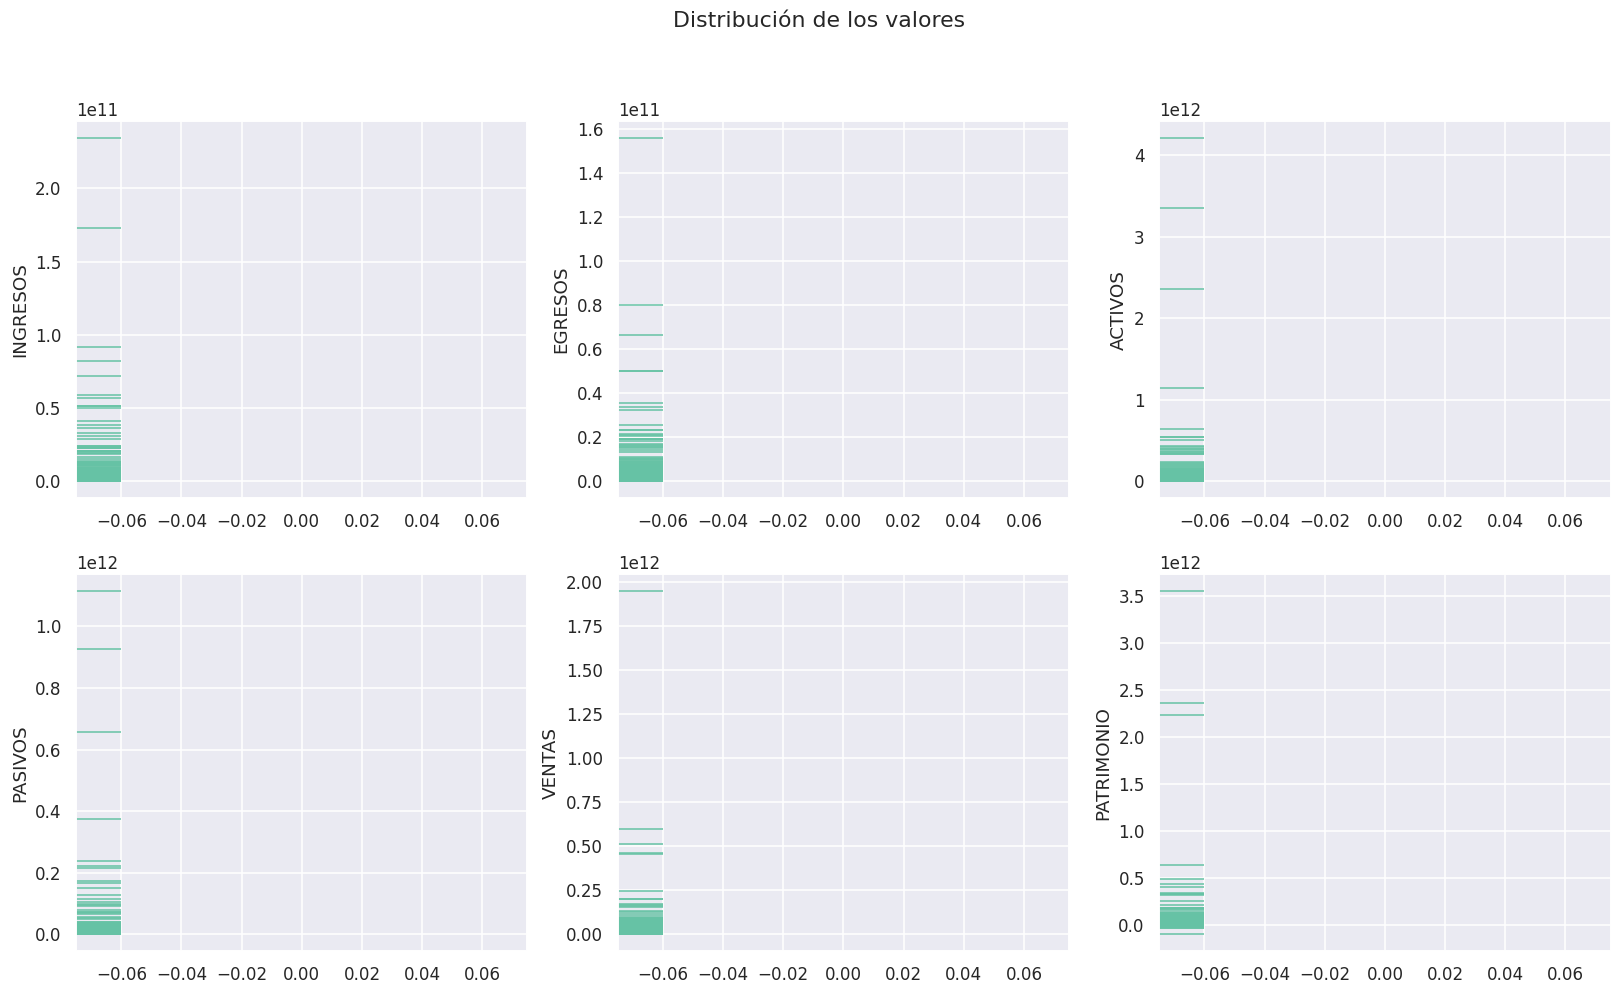

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
fig.suptitle('Distribución de los valores')

sns.rugplot(ax=axes[0, 0],y = df['INGRESOS'], height=0.1);
sns.rugplot(ax=axes[0, 1],y = df['EGRESOS'], height=0.1);
sns.rugplot(ax=axes[0, 2],y = df['ACTIVOS'], height=0.1);
sns.rugplot(ax=axes[1, 0],y = df['PASIVOS'], height=0.1);
sns.rugplot(ax=axes[1, 1],y = df['VENTAS'], height=0.1);
sns.rugplot(ax=axes[1, 2],y = df['PATRIMONIO'], height=0.1);

Ya se puede notar que la mayoría de datos se concentra en valores cercanos a 0 para las variables financieras. 

Es importante revisar qué porcentaje es igual a 0. Demasiados valores igual a 0 serán de poca utilidad para nuestro modelo

In [ ]:
def info_ceros_and_less(df,column):
    """
        Funcion informativa de valores 0
    """
    menos_de_0 = df[df[column] < 0]
    igual_0 = df[df[column] == 0]
    print("Para la columna ", column, " hay ", len(menos_de_0), " valores menores que 0")
    print("Para la columna ", column, " hay ", len(igual_0), " valores iguales que 0")
    print("porcentaje de == 0´s : ", (len(igual_0)/len(df))*100)
    print("\n -----================================ \n")

In [ ]:
for var in var_financieras:
  info_ceros_and_less(df,var)

Para la columna  INGRESOS  hay  0  valores menores que 0
Para la columna  INGRESOS  hay  3571  valores iguales que 0
porcentaje de == 0´s :  20.4970726667432

 -----================================ 

Para la columna  EGRESOS  hay  0  valores menores que 0
Para la columna  EGRESOS  hay  10467  valores iguales que 0
porcentaje de == 0´s :  60.07921019400758

 -----================================ 

Para la columna  ACTIVOS  hay  0  valores menores que 0
Para la columna  ACTIVOS  hay  1710  valores iguales que 0
porcentaje de == 0´s :  9.81517621398232

 -----================================ 

Para la columna  PASIVOS  hay  0  valores menores que 0
Para la columna  PASIVOS  hay  12631  valores iguales que 0
porcentaje de == 0´s :  72.50028699345656

 -----================================ 

Para la columna  VENTAS  hay  0  valores menores que 0
Para la columna  VENTAS  hay  3202  valores iguales que 0
porcentaje de == 0´s :  18.37906095741017

 -----================================ 

Para 

Para las columnas EGRESOS y PASIVOS hay una gran concentracion de valores iguales a 0 (60%, 72%). Sera necesario crear una permutación donde no se incluyan estos valores para entrenar el modelo

### 3.5 fecha_constitucion

In [ ]:
df['fecha_review'] = pd.DatetimeIndex(pd.to_datetime(df["fecha_constitucion"],format='%Y%m%d', errors='coerce')).year

In [ ]:
def trans_fecha(yearnace):
    actual = 2021
    anios = None
    if yearnace is not None:
        try:
            anios = actual - yearnace
        except:
            anios = 0
    return anios

In [ ]:
df['edad']= df['fecha_review'].apply(trans_fecha)

In [ ]:
fig = px.histogram(df, x="edad",color_discrete_sequence=px.colors.qualitative.Set3)
fig.show()

Hay fechas con valores negativos, la distribución y naturaleza de la variable no representa mucha utilidad para nuestro modelo

### 3.6 TIPO_SOCIEDAD

In [ ]:
df['TIPO_SOCIEDAD'].value_counts()

Ent. Sin Animo De L    12212
No Aplica               2629
S. Anon. Simp. Sas      1441
Asociacion Civil         680
Empresa Unipersonal      138
Sociedad Limitada        126
Sociedad Anonima          61
Union Temporal            49
Sociedad Colectiva        42
Consorcio                 14
S. En Com. Por Acci       13
S. En Com. Simple          9
Sociedad De Hecho          5
Sucursal De S. Extr        2
Soc.agr.trans Sat          1
Name: TIPO_SOCIEDAD, dtype: int64

In [ ]:
data = df['TIPO_SOCIEDAD'].value_counts(dropna=False)
data_labels = list(data.index)
data_values = list(data.values)

In [ ]:
fig = px.pie(df, values=data_values, names=data_labels, color_discrete_sequence=px.colors.qualitative.Set3)
fig.show()

El valor “Ent. Sin Ánimo de L” concentra el 70.1% de los datos y luego hay un 15,1 % para “No Aplica” esto concentra el 85% de los datos dejando pocas muestras al resto de posibles valores.
 
Debido a su distribución no es una variable indicada para usar en nuestro modelo


### 3.7 ENTIDAD

In [ ]:
df['ENTIDAD'].value_counts()

Otro                                        4967
Establecimiento Publico                     3912
Corporaciones Y Asociaciones                3390
Fundaciones                                 3030
Conjuntos Residenciales                      817
Cooperativas                                 327
Entidades Religiosas No Catolicas            250
Personas Juridicas De Derechos Canonicos     150
Empresa De Servicios Publicos Domicilia      115
Sociedad Economica Mixta                     111
Sindicatos                                   100
Empresa Social Del Estado                     83
Fondos De Empleados                           81
Empresa Industrial Y Comercial Del Esta       34
Entidades Financieras                         33
Precooperativas                               13
Fondos De Inversion                            9
Name: ENTIDAD, dtype: int64

In [ ]:
data = df['ENTIDAD'].value_counts(dropna=False)
data_labels = list(data.index)
data_values = list(data.values)

In [ ]:
fig = px.pie(df, values=data_values, names=data_labels, color_discrete_sequence=px.colors.qualitative.Set3)
fig.show()

Hay una buena distribución para valores de ENTIDAD, podemos considerar su uso como variable categorica

### 3.8 CAPTACIONES CRÉDITO Y DÉBITOS
Las captaciones se refieren a montos que ingresan a las cuentas (por conceptos de créditos o débitos)

Por ejemplo una cuenta de ahorro a la cual consignan un salario y el cliente la usa luego para pagar un producto 

In [ ]:
captaciones = ['CAPTACIONES_CREDITO','CAPTACIONES_DEBITO']
df[captaciones].describe()

,CAPTACIONES_CREDITO,CAPTACIONES_DEBITO
count,1.742200e+04,1.742200e+04
mean,4.328798e+08,2.905149e+08
std,5.729846e+09,3.549172e+09
min,0.000000e+00,0.000000e+00
25%,9.634288e+01,0.000000e+00
50%,1.306111e+06,5.076255e+04
75%,3.555144e+07,7.494086e+05
max,4.617914e+11,2.495395e+11


In [ ]:
for i in captaciones:
  info_ceros_and_less(df,i)

Para la columna  CAPTACIONES_CREDITO  hay  0  valores menores que 0
Para la columna  CAPTACIONES_CREDITO  hay  496  valores iguales que 0
porcentaje de == 0´s :  2.8469750889679712

 -----================================ 

Para la columna  CAPTACIONES_DEBITO  hay  0  valores menores que 0
Para la columna  CAPTACIONES_DEBITO  hay  4907  valores iguales que 0
porcentaje de == 0´s :  28.165537825737573

 -----================================ 



la concentración de valores en 0 no parece tan alta. Para CAPTACIONES_CREDITO ya podemos ver valores mayores que 0 en el q1 (25%), para las CAPTACIONES_DEBITO los valores mayores que 0 aparecen en el q2.

In [ ]:
def describe_montos(df,column):
  print(df[column].describe().apply(lambda x: format(x, 'f')))
  data_bins = pd.Series(dtype="object")
  data_bins = pd.cut(df[column], [-10e20,-0.001,0,100000,1000000,10000000,100000000,1000000000],
                     labels=["> 0","Igual a 0", "< 100.000", "100.000 - 1'000.000","1'000.000 - 10'000.000", 
                             "10'000.000 - 100'000.000", "> 100 Millones"])
  fig = px.histogram(df, x=data_bins, color_discrete_sequence=px.colors.qualitative.Set3, labels={'x':column}).update_xaxes(categoryorder='total descending')
  fig.show()

In [ ]:
describe_montos(df,"CAPTACIONES_CREDITO")

count           17422.000000
mean        432879809.223537
std        5729846403.906881
min                 0.000000
25%                96.342876
50%           1306110.923950
75%          35551436.874863
max      461791397464.050781
Name: CAPTACIONES_CREDITO, dtype: object


In [ ]:
describe_montos(df,"CAPTACIONES_DEBITO")

count           17422.000000
mean        290514855.349383
std        3549172118.678012
min                 0.000000
25%                 0.000000
50%             50762.553758
75%            749408.589885
max      249539500906.440399
Name: CAPTACIONES_DEBITO, dtype: object


CAPTACIONES_DEBITO presenta una concentración más alta de valores en 0, sin embargo aún no es alarmante y su porcentaje de representación en los datos es relativamente bajo. En general los datos de ambas variables se comportan de la manera esperada 

### 3.9 COLOCACIONES_CREDITO, COLOCACIONES_DEBITO
Las colocaciones corresponden a las operaciones de 'credito' o dinero que se pone en circulación

Tienen operaciondes credito (cuando se desembolsa un credito) y debito cuando se realiza un pago al producto

In [ ]:
colocaciones = ['COLOCACIONES_CREDITO','COLOCACIONES_DEBITO']
df[colocaciones].describe()

,COLOCACIONES_CREDITO,COLOCACIONES_DEBITO
count,1.742200e+04,1.742200e+04
mean,1.494853e+08,2.126431e+08
std,6.982811e+09,1.044628e+10
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,0.000000e+00,0.000000e+00
75%,0.000000e+00,0.000000e+00
max,6.419369e+11,9.599513e+11


Hay una enorme concentración de ceros, incluso en el 75% de los datos los valores siguen siendo 0. **Esta variable puede no resultar óptima para el modelo**

In [ ]:
for i in colocaciones:
  describe_montos(df,i)

count           17422.000000
mean        149485264.257569
std        6982810730.513598
min                 0.000000
25%                 0.000000
50%                 0.000000
75%                 0.000000
max      641936920206.909668
Name: COLOCACIONES_CREDITO, dtype: object


count           17422.000000
mean        212643131.188601
std       10446283381.609243
min                 0.000000
25%                 0.000000
50%                 0.000000
75%                 0.000000
max      959951251970.216797
Name: COLOCACIONES_DEBITO, dtype: object


### 3.10 TRX_CAPTACIONES_CREDITO, TRX_CAPTACIONES_DEBITO
Se refieren a las frecuencias con las que se realizan las transacciones de captaciones


In [ ]:
trx_captaciones = ['TRX_CAPTACIONES_CREDITO', 'TRX_CAPTACIONES_DEBITO']
df[trx_captaciones].describe()

,TRX_CAPTACIONES_CREDITO,TRX_CAPTACIONES_DEBITO
count,17422.000000,17422.000000
mean,248.068993,295.118700
std,2644.150260,1341.660684
min,0.000000,0.000000
25%,14.000000,1.000000
50%,27.000000,25.000000
75%,135.000000,146.000000
max,318567.000000,56188.000000


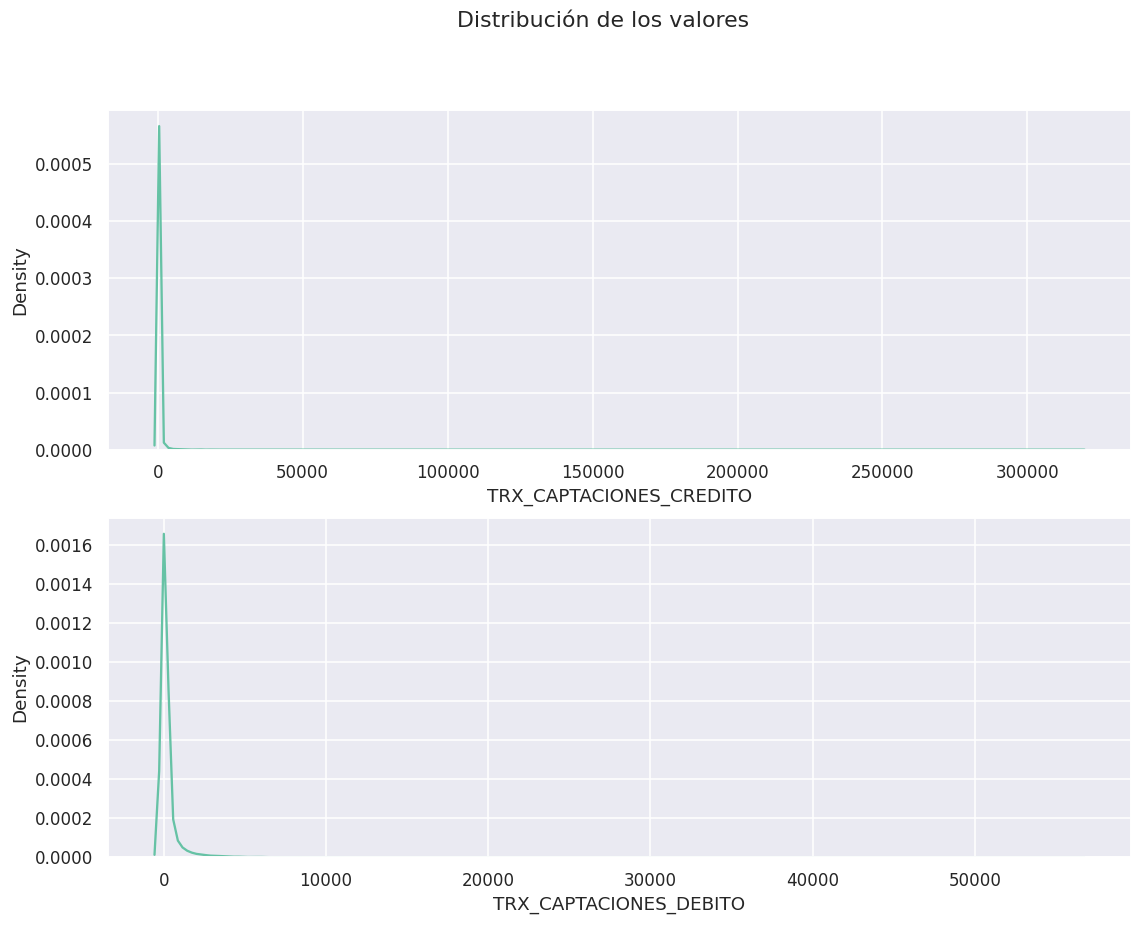

In [ ]:
fig, axes = plt.subplots(2, 1,figsize=(12, 9))
fig.suptitle('Distribución de los valores')

sns.kdeplot(ax=axes[0],x= df['TRX_CAPTACIONES_CREDITO']);

sns.kdeplot(ax=axes[1],x= df['TRX_CAPTACIONES_DEBITO']);

Los valores de 0 o más pequeños son más comunes para la frecuencia de transacciones. Será interesante ver el comportamiento del modelo sin incluir la variable de frecuencias en una de las permutaciones

### 3.11 TRX_COLOCACIONES_CREDITO, TRX_COLOCACIONES_DEBITO
Se refieren a las frecuencias con las que se realizan las transacciones de colocaciones

In [ ]:
trx_colocaciones = ['TRX_COLOCACIONES_CREDITO', 'TRX_COLOCACIONES_DEBITO']
df[trx_colocaciones].describe()

,TRX_COLOCACIONES_CREDITO,TRX_COLOCACIONES_DEBITO
count,17422.000000,17422.000000
mean,5.975663,0.755826
std,136.075728,13.967652
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.000000,0.000000
75%,0.000000,0.000000
max,10998.000000,1118.000000


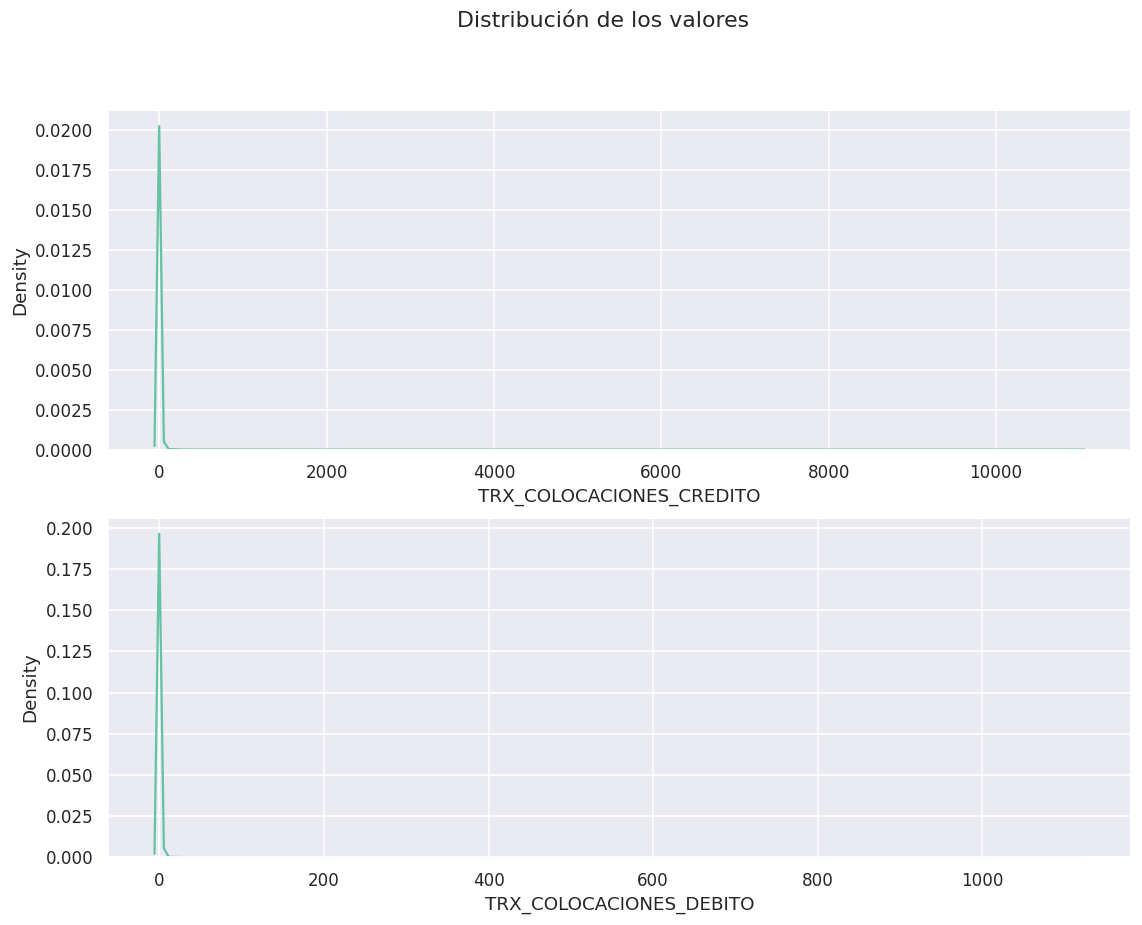

In [ ]:
fig, axes = plt.subplots(2, 1,figsize=(12, 9))
fig.suptitle('Distribución de los valores')

sns.kdeplot(ax=axes[0],x= df['TRX_COLOCACIONES_CREDITO']);

sns.kdeplot(ax=axes[1],x= df['TRX_COLOCACIONES_DEBITO']);

Hay una alta concentración de 0s tambien para las frecuencias de colocaciones

### 3.12 EFECTIVO_CREDITO, EFECTIVO_DEBITO
Son las operaciones realizadas con dineros en efectivo

In [ ]:
efectivos = ['EFECTIVO_CREDITO', 'EFECTIVO_DEBITO']
df[efectivos].describe()

,EFECTIVO_CREDITO,EFECTIVO_DEBITO
count,1.742200e+04,1.742200e+04
mean,4.646978e+07,1.176486e+08
std,5.113244e+08,2.428226e+09
min,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00
50%,1.023400e+05,1.792019e+06
75%,5.771464e+06,2.463859e+07
max,2.481354e+10,1.791718e+11


In [ ]:
for i in efectivos:
  describe_montos(df,i)

count          17422.000000
mean        46469783.569492
std        511324354.563147
min                0.000000
25%                0.000000
50%           102340.000000
75%          5771464.300000
max      24813544963.496803
Name: EFECTIVO_CREDITO, dtype: object


count           17422.000000
mean        117648585.758306
std        2428226143.231559
min                 0.000000
25%                 0.000000
50%           1792019.453000
75%          24638591.661250
max      179171755000.000061
Name: EFECTIVO_DEBITO, dtype: object


In [ ]:
for i in efectivos:
  info_ceros_and_less(df,i)

Para la columna  EFECTIVO_CREDITO  hay  0  valores menores que 0
Para la columna  EFECTIVO_CREDITO  hay  7537  valores iguales que 0
porcentaje de == 0´s :  43.261393640225

 -----================================ 

Para la columna  EFECTIVO_DEBITO  hay  0  valores menores que 0
Para la columna  EFECTIVO_DEBITO  hay  6818  valores iguales que 0
porcentaje de == 0´s :  39.13442773504764

 -----================================ 



Hay una alta concentración de 0’s, sin embargo este comportamiento es esperado y aun asi no pasa del 50% de los datos

### TRX_EFECTIVO_CREDITO, TRX_EFECTIVO_DEBITO

In [ ]:
trx_efectivo = ['TRX_EFECTIVO_CREDITO', 'TRX_EFECTIVO_DEBITO']
df[trx_efectivo].describe()

,TRX_EFECTIVO_CREDITO,TRX_EFECTIVO_DEBITO
count,17422.000000,17422.000000
mean,55.328952,30.317472
std,509.288616,120.938595
min,0.000000,0.000000
25%,0.000000,0.000000
50%,1.000000,2.000000
75%,9.000000,23.000000
max,34362.000000,8896.000000


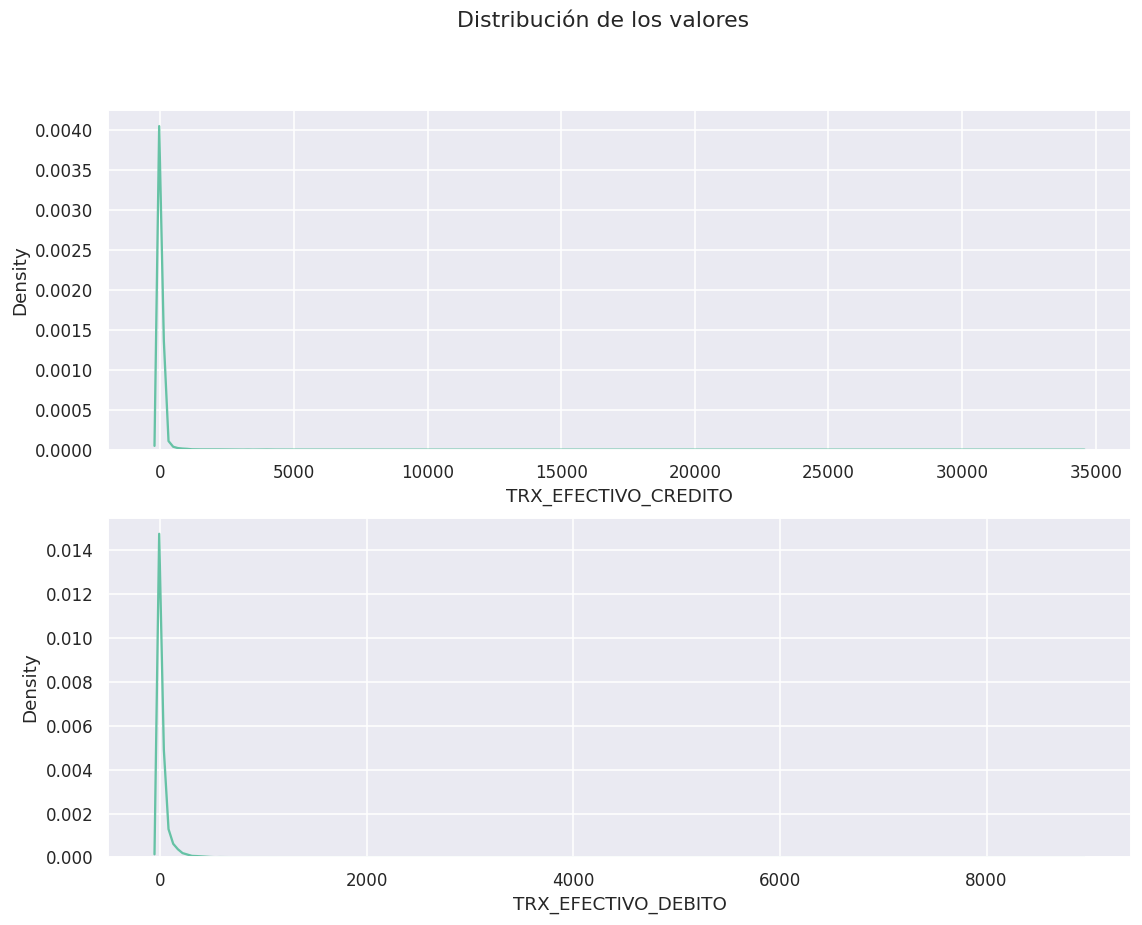

In [ ]:
fig, axes = plt.subplots(2, 1,figsize=(12, 9))
fig.suptitle('Distribución de los valores')

sns.kdeplot(ax=axes[0],x= df['TRX_EFECTIVO_CREDITO']);

sns.kdeplot(ax=axes[1],x= df['TRX_EFECTIVO_DEBITO']);

# Conclusiones de la exploración

## Variables que se descartan
- **ACT_ECO** Porque el 96% de los valores corresponde a la clase "servicios". 
 
- **CIIU** Código de la actividad, no es útil para la segmentación
 
- **fecha_constitucion** No tiene información que sea considera relevante
 
- **TIPO_SOCIEDAD**  70% de los datos pertenecen a “Ent sin ánimo de lucro”  y otro 15,1 % en NO APLICA

## Tratamiento para las variables.
1. Eliminar posibles negativos en:
- INGRESOS
- EGRESOS
- ACTIVOS
- PASIVOS
- VENTAS

No tienen sentido los valores negativos en estas variables

2. Crear la variable **"sum_montos"** que corresponde a la suma de:
- CAPTACIONES_CREDITO
- CAPTACIONES_DEBITO
- COLOCACIONES_CREDITO
- COLOCACIONES_DEBITO
- EFECTIVO_CREDITO
- EFECTIVO_DEBITO

3. Revisar el tratamiento de los outliers para el modelo (algoritmo de agrupamiento para detección)

3. Eliminar outliers para el entrenamiento del modelo.

4. Tratar variables categoricas

5. Crear permutaciones y definir modelos de clustering a usar
 